# ATSC-500 Assignment IV

In [1]:
import numpy as np
import netCDF4 as nc
from glob import glob
from os.path import basename
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
% matplotlib inline

In [2]:
name = glob('_data/ATSC-500/tropical_subset.nc')[0]
nc_obj = nc.Dataset(name)
Z = nc_obj.variables['z'][...]
X = nc_obj.variables['x'][...]
Y = nc_obj.variables['y'][...]
T = nc_obj.variables['TABS'][0,...]
P = nc_obj.variables['p'][...]*100.0 # Pa
W = nc_obj.variables['W'][0,...]
QV = nc_obj.variables['QV'][0,...] # g/kg
QN = nc_obj.variables['QN'][0,...] # CLW g/kg
nc_obj.close()
# form (x, y) into 2d grids
gridx, gridy = np.meshgrid(X, Y)

## Assignment i - comment on the difference of heat fluxes between 200 and 800 m

Sensible heat flux $F(H_s)$:

$$
F(H_s) = w\cdot(c_{p}\Delta T\cdot\rho)
$$

For dry air at ~300K, the specific heat capacity for constant pressure, $c_{pd}=1004\ \mathrm{J\cdot kg^{-1}\cdot K^{-1}}$

Applying the idea gas law:

$$
\rho = \frac{p}{R_dT_v}
$$

Latent heat flux $F(H_l)$ for the phase change between vapor and water:

$$
F(H_l) = w\cdot(L_v\Delta q\cdot\rho)
$$

According to *Kirchhoff's equation*:

$$
\frac{dL_v}{dT} = c_{pv}-c_w
$$

Based on the state of $\mathrm{0^\circ C}$:

$$
L_v = 2.5\times 10^6 - 2323\cdot(T-273.15)\ \mathrm{J\cdot kg^{-1}}
$$

In [3]:
def reynolds_ave(data):
    """
    Assuming 3-dim input data[Z, space]
    """
    ave = np.mean(data, (1, 2))
    return ave, (data.T-ave).T

def kirchhoff(T):
    return 2.5e6 - 2323*(T-273.15)

def Tv(T, RMIX):
    return (1+0.608*RMIX)*T

In [12]:
zind = [0, 0]
zind[0] = np.searchsorted(Z, 200)
zind[1] = np.searchsorted(Z, 800)
# Reynolds averaging
T_mean, T_anom = reynolds_ave(T[zind, ...])
W_mean, W_anom = reynolds_ave(W[zind, ...])
Qv_mean, Qv_anom = reynolds_ave(1e-3*QV[zind, ...]) # g/kg -> rmix
# Constants
Rd = 286.888
Cpd = 1004
Lv = kirchhoff(T_mean)
# Heat fluxes @ meanflow
rho_mean = P[zind, ...]/(Rd*Tv(T_mean, Qv_mean))
F_Hs = ((W_anom.T*T_mean)*rho_mean*Cpd).T
F_Hl = (((W_anom.T*Qv_mean)*rho_mean)*Lv).T
# Heat fluxes @ turbulence

F_Hs_turb = ((W_anom*T_anom).T*rho_mean).T*Cpd
F_Hl_turb = (((W_anom*Qv_anom).T*rho_mean)*Lv).T

In [13]:
def comparisom_plots(Hs, Hl, bins=np.linspace(-60, 60, 100), ylims=[50, 75], key='Mean'):
    fig, AX = plt.subplots(2, 2, figsize=(12, 6))
    AX = AX.flat
    for ax in AX:
        ax.grid(linestyle=':')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_tick_params(labelsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
        [j.set_linewidth(2.5) for j in ax.spines.values()]
        ax.tick_params(axis="both", which="both", bottom="off", top="off", \
               labelbottom="on", left="off", right="off", labelleft="on")
    for ax in AX[[0, 2]]:
        ax.set_ylim([0, ylims[0]])
    for ax in AX[[1, 3]]:
        ax.set_ylim([0, ylims[1]])
        
    AX[0].set_title('(a) '+key+' sensible heat flux on 200 m', fontsize=14)    
    AX[1].set_title('(b) '+key+' latent heat flux on 200 m', fontsize=14) 
    AX[2].set_title('(c) '+key+' sensible heat flux on 800 m', fontsize=14) 
    AX[3].set_title('(d) '+key+' latent heat flux on 800 m', fontsize=14) 

    AX[0].tick_params(labelbottom="off")
    AX[1].tick_params(labelbottom="off")
    AX[2].set_xlabel(key+' sensible heat flux bins', fontsize=14)
    AX[3].set_xlabel(key+' latent heat flux bins', fontsize=14)
    AX[0].text(-0.175, 0, r"Number of grids in each bin", \
               va='center', rotation='vertical', transform=AX[0].transAxes, fontsize=14)

    AX[0].hist(Hs[0, :].flat, histtype='step', lw=2.5, color='r', bins=bins);
    AX[1].hist(Hl[0, :].flat, histtype='step', lw=2.5, bins=bins);
    AX[2].hist(Hs[1, :].flat, histtype='step', lw=2.5, color='r', bins=bins);
    AX[3].hist(Hl[1, :].flat, histtype='step', lw=2.5, bins=bins);
    plt.tight_layout()

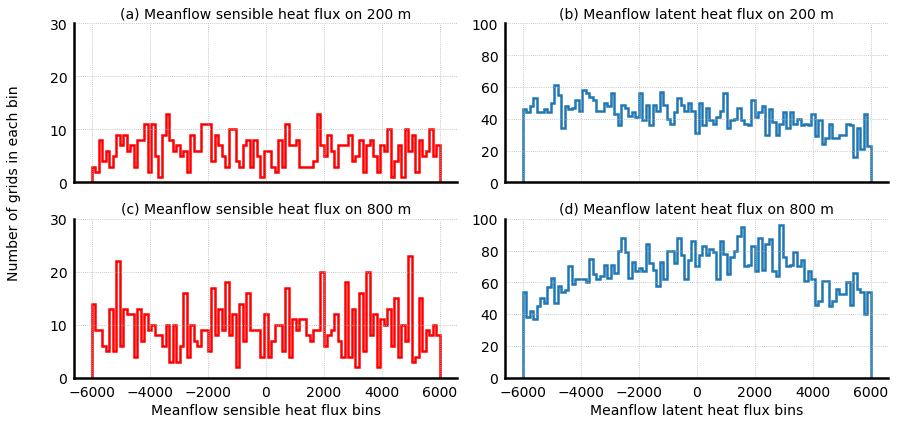

In [14]:
comparisom_plots(F_Hs, F_Hl, bins=np.linspace(-6e3, 6e3, 100), ylims=[30, 100], key='Meanflow')

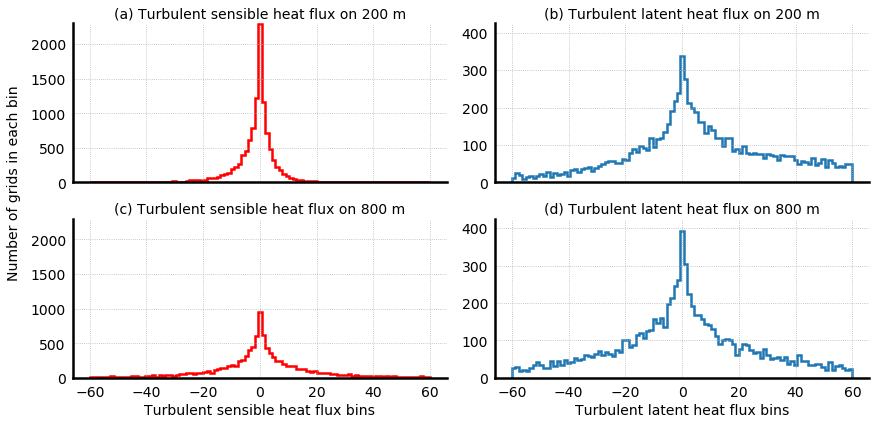

In [15]:
comparisom_plots(F_Hs_turb, F_Hl_turb, bins=np.linspace(-60, 60, 100), ylims=[2300, 425], key='Turbulent')

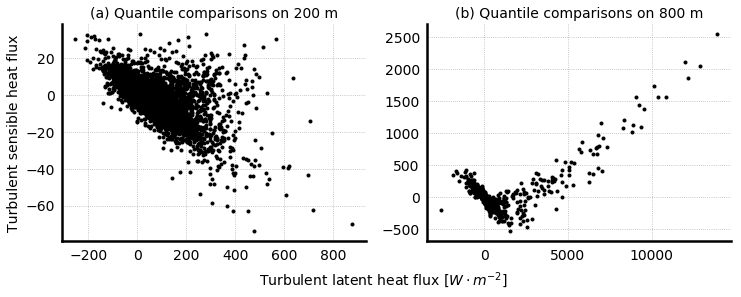

In [16]:
fig, AX = plt.subplots(1, 2, figsize=(12, 4))
AX = AX.flat

for ax in AX:
    ax.grid(linestyle=':')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom="off", top="off", \
           labelbottom="on", left="off", right="off", labelleft="on")
AX[0].set_title('(a) Quantile comparisons on 200 m', fontsize=14)
AX[0].set_ylabel('Turbulent sensible heat flux', fontsize=14)
AX[0].text(0.65, -0.2, r"Turbulent latent heat flux [$W\cdot m^{-2}$]", transform=AX[0].transAxes, fontsize=14)
AX[1].set_title('(b) Quantile comparisons on 800 m', fontsize=14)

AX[0].plot(F_Hl_turb[0, :].flat, F_Hs_turb[0, :].flat, '.k');
AX[1].plot(F_Hl_turb[1, :].flat, F_Hs_turb[1, :].flat, '.k');

/home/yingkai/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


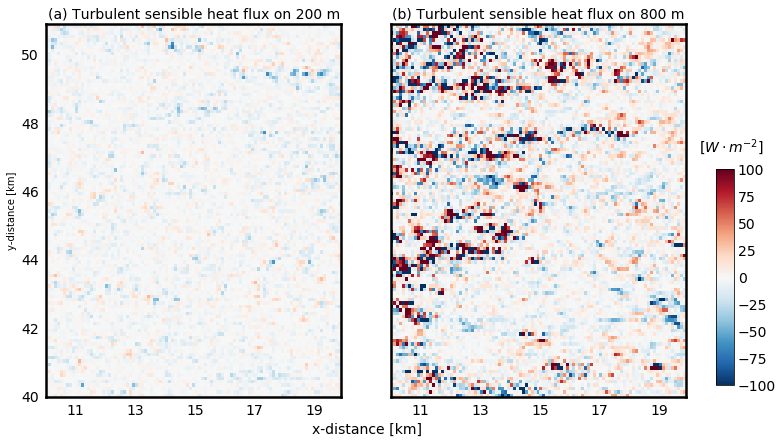

In [17]:
fig, AX = plt.subplots(1, 2, figsize=(10, 6))
AX = AX.flat
for ax in AX:
    ax.grid(linestyle=':')
    ax.set_xticks(np.arange(11, 21, 2))
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom="off", top="off", \
           labelbottom="on", left="off", right="off", labelleft="on")

AX[1].tick_params(labelleft="off")
AX[0].set_ylabel('y-distance [km]')
AX[0].text(0.9, -0.1, 'x-distance [km]', transform=AX[0].transAxes, fontsize=14)
AX[0].set_title('(a) Turbulent sensible heat flux on 200 m', fontsize=14)
AX[1].set_title('(b) Turbulent sensible heat flux on 800 m', fontsize=14)

CS = AX[0].pcolor(gridx*1e-3, gridy*1e-3, F_Hs_turb[0, :, :], vmin=-100, vmax=100, cmap=plt.cm.RdBu_r)
AX[1].pcolor(gridx*1e-3, gridy*1e-3, F_Hs_turb[1, :, :], vmin=-100, vmax=100, cmap=plt.cm.RdBu_r)

cax = fig.add_axes([1, 0.1, 0.025, 0.5])
CBar = fig.colorbar(CS, cax=cax, orientation='vertical')
CBar.ax.tick_params(axis='y', length=0, labelsize=14)
CBar.set_label('[$W\cdot m^{-2}$]', fontsize=14, labelpad=-45, y=1.15, rotation=360)

plt.tight_layout()

## Commenting on the diffierence

For turbulent sensible heat flux, 800 m is significantly higher than 200 m. 

But for turbulent latent heat flux, more 800 m grids have values close to zero. 

The diffierence is likely due to the ascending turbulent flow and the entrainment of dry air on the 800 m level.

For the covariance of turbulent sensible and latent heat fluxes, on 200 m level, a stable negative correlation can be found. 

But on 800 m level, some grids are showing positive relations with very high sensible heat fluxes. 

The the negative relation of the two heat component on 200 m indicates that, the total tubulent heat flux in this layer has no big variance, and it is within the definition of surface layer.

On 800 m, the strong vertial movement in the mixing layer brings energy from the meanflow to the turbulence, which yields to a rapid increase of sensible heat flux.

## Assignment ii - Showing cloud profile from 0 to 3 km

Following the definition of the course material, here if the cloud liquid water content  (CLW) of the grid is larger than 0.01, then this grid represents clouds.

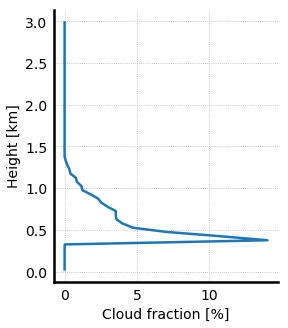

In [18]:
grid_shape = QN.shape
cloud_frac = np.zeros(grid_shape)
cloud_frac[QN >= 0.01] = 1.0
cloud_frac = np.sum(cloud_frac, (1, 2))/(grid_shape[1]*grid_shape[2])*100
flag = Z <= 3000
# ========== Plot ========== #
fig = plt.figure(figsize=(4, 5))
ax = fig.gca()

ax.grid(linestyle=':')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[j.set_linewidth(2.5) for j in ax.spines.values()]
ax.tick_params(axis="both", which="both", bottom="off", top="off", \
       labelbottom="on", left="off", right="off", labelleft="on")
ax.set_xlabel('Cloud fraction [%]', fontsize=14)
ax.set_ylabel('Height [km]', fontsize=14)
ax.plot(cloud_frac[flag], Z[flag]*1e-3, lw=2.5)

In [19]:
# ========== Checking profiles ========== #

# flag_highvals = np.where(np.logical_and(F_Hl_turb[1, :] > 1000., F_Hs_turb[1, :] > 1000))
# profile_inds = list(zip(*flag_highvals))

# fig, AX = plt.subplots(1,4,figsize=(12, 6))

# for ax in AX:
#     ax.grid(linestyle=':')
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.xaxis.set_tick_params(labelsize=14)
#     ax.yaxis.set_tick_params(labelsize=14)
    
#     [j.set_linewidth(2.5) for j in ax.spines.values()]
#     ax.tick_params(axis="both", which="both", bottom="off", top="off", \
#            labelbottom="on", left="off", right="off", labelleft="on")
#     ax.set_ylim([0, 3250])
# for ax in AX[1:]:
#     ax.tick_params(labelleft="off")

# for y, x in profile_inds:
#     AX[0].plot(T[:,y,x], Z)
#     AX[1].plot(W[:,y,x], Z)
#     AX[2].plot(QV[:,y,x], Z)
#     AX[3].plot(QN[:,y,x], Z)
    
# AX[0].set_title('(a) Temperature', fontsize=14)
# AX[1].set_title('(b) Vertical velosity', fontsize=14)
# AX[2].set_title('(c) Mixing ratio', fontsize=14)
# AX[3].set_title('(d) Liquid water content', fontsize=14)

# AX[0].set(xlim=(273.15, 300), xlabel='[K]')
# AX[1].set(xlim=(-1, 4),xlabel='[m/s]')
# AX[2].set(xlim=(5, 18),xlabel='[g/kg]')
# AX[3].set(xlim=(0, 1.5),xlabel='[g/kg]')

# plt.tight_layout()